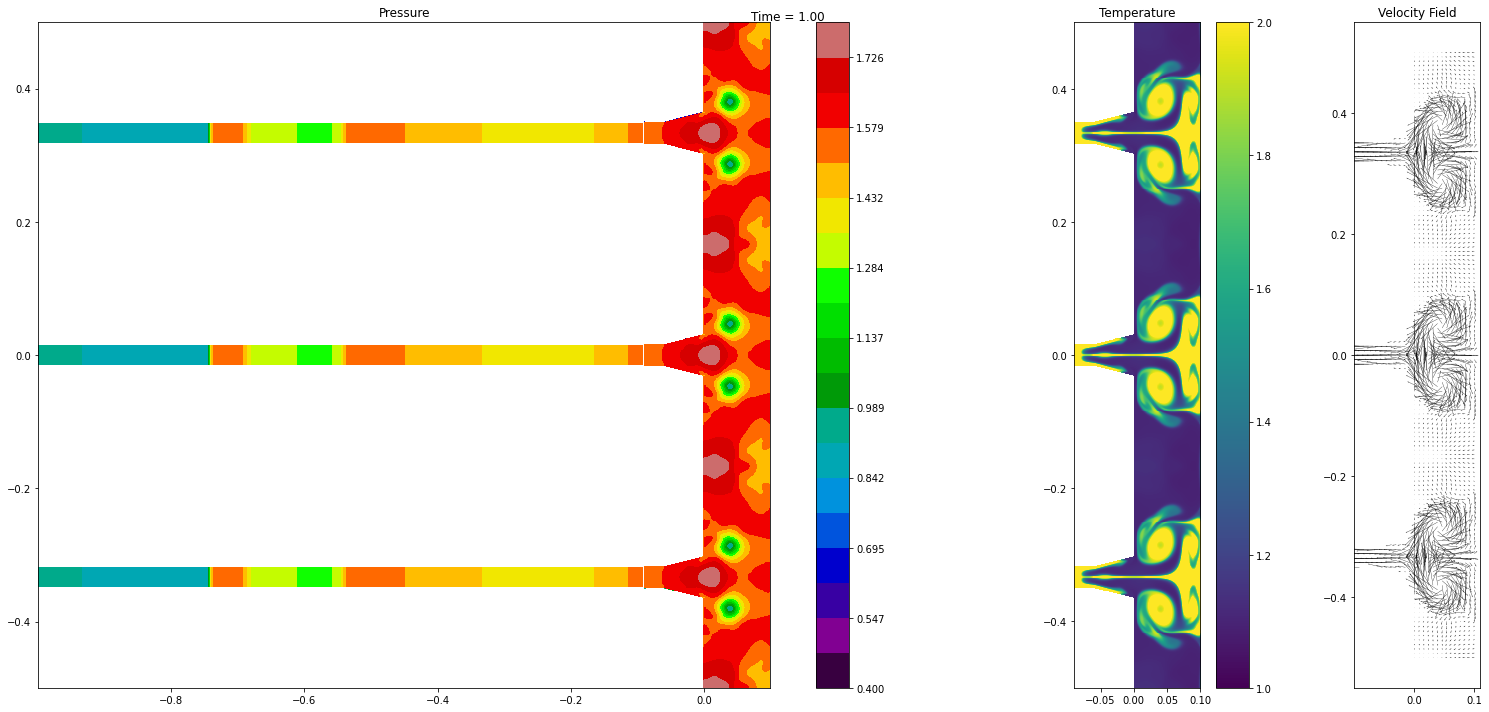

In [63]:
import sys
sys.path.append('/srv/public/Maikel/FiniteVolumeSolver/extra/')

import yt
import os
import numpy as np
import matplotlib.pyplot as plt
import amrex.plotfiles as da
import itertools

valueString = 'Pressure' # which value we want to plot
# possible values are: ['Density', 'Energy', 'Momentum_0', 'Momentum_1', 'Pressure', 'Species_0', 'Species_1', 'SpeedOfSound', 'vfrac']

# dataPath = "/srv/public/Maikel/FiniteVolumeSolver/build_2D-Release/SEC_Plenum_TurbineBoundary/"
# dataPath = "/srv/public/Maikel/FiniteVolumeSolver/build_2D-Release/SEC_Plenum_HLLEM_MinMod/"
# dataPath = "/srv/public/Maikel/FiniteVolumeSolver/build_2D-Release/SEC_Plenum_HLLEM_Larrouturou_Upwind"
# dataPath = "/srv/public/Maikel/FiniteVolumeSolver/build_2D-Debug/SEC_Plenum_HLLEM_Larrouturou_Upwind"
# dataPath = "/srv/public/Maikel/FiniteVolumeSolver/build_2D-Debug/SEC_Plenum_HLLEM_Upwind"
# dataPath = "/srv/public/Maikel/FiniteVolumeSolver/build_2D-Release/SEC_Plenum_HLLEM_Upwind"
dataPath = "/srv/public/Maikel/FiniteVolumeSolver/build_2D-Release/SEC_Plenum/average_outer_state/"
outPath = dataPath
plenum_number = 0

def PrintProgress(i, plotfiles):
  ny = len(plotfiles)
  progress = int(100.0 * float(i) / (ny - 1))
  print('[{:3d}%] Reading plotfile {}'.format(progress, plotfiles[i]))

yt.funcs.mylog.setLevel(50)
output_dir = dataPath+'/Plotfiles/Plenum%i'%(plenum_number)

dirs = os.listdir(output_dir)
plotfiles = ['{}/{}'.format(output_dir, plt) for plt in dirs]
list.sort(plotfiles)
plotfiles = plotfiles[::1]

output_path = '{}/Visualization2'.format(outPath)
os.makedirs(output_path, exist_ok=True)

#for i, plotfile in itertools.dropwhile(lambda x: x[0] < 329, enumerate(plotfiles)):
mylist = list(enumerate(plotfiles))
for i, plotfile in mylist[200:201]:
   # get Tube Data
   temp = plotfile.split("/")[-1]
   Tubes = [0,1,2]
   
   Tube_p = []
   extent_tube = []
   
   for tube_number in Tubes:
      Tube_Dir = dataPath+'/Plotfiles/Tube%i/'%tube_number
      (p_tube), current_time, extent_temp = da.load(Tube_Dir+temp, ["Pressure"], False)
      Tube_p.append(p_tube)
      extent_tube.append(extent_temp)
   
   def stackTubeDataTo2D(Tube_datalist):
     # all Tubedata is 1D but for contourf we need at least 2D data. so simply stack twice the 1d array
     for i, el in enumerate(Tube_datalist):
        el = np.squeeze(el)
        Tube_datalist[i] = np.stack((el,el))
     return Tube_datalist
   Tube_p = stackTubeDataTo2D(Tube_p)


   #PrintProgress(i, plotfiles)
   (p, rho, rhou, rhov, c, vols), current_time, extent = da.load(plotfile, ["Pressure", "Density", "Momentum_0", "Momentum_1", "SpeedOfSound", 'vfrac'])
   f, axs = plt.subplots(nrows=1, ncols=3, figsize=(22, 10), gridspec_kw={'width_ratios': [3, 1, 1]})
   f.suptitle('Time = {:.2f}'.format(current_time))
   # pressure image
   p = np.where(vols > 1e-14, p, np.nan)
   levels = np.linspace(0.4, 1.8, 20)
   pressure_options = {
     'origin': 'lower',
     'interpolation': 'none',
     'vmin': 0.4,
     'vmax': 1.8,
     'cmap': 'nipy_spectral',
     'levels': levels
   }
   im_p = axs[0].contourf(p, extent=extent, **pressure_options)
   for i, tube_p in enumerate(Tube_p):
      midpoint = 0.5 * (extent_tube[i][2] + extent_tube[i][3])
      D = 0.03
      lower = midpoint - D
      upper = midpoint + D
      extent_tube[i][2] = lower
      extent_tube[i][3] = upper
      axs[0].contourf(tube_p, extent=extent_tube[i], **pressure_options)
   axs[0].set_title('Pressure')
   axs[0].set(aspect='equal')
   plt.colorbar(im_p, ax=axs[0])
   # temperature image
   T = p / rho
   im_T = axs[1].imshow(T, origin='lower', vmin=1.0, vmax=2.0, interpolation='none', extent=extent)
   axs[1].set_title('Temperature')
   axs[1].set(aspect='equal')
   plt.colorbar(im_T, ax=axs[1])
   # velocity field
   u = np.where(vols > 1e-14, rhou / rho, np.nan)
   v = np.where(vols > 1e-14, rhov / rho, np.nan)
   skip = 5
   scale = 15.0
   x = np.linspace(*extent[0:2], num=u[::skip, ::skip].shape[1], endpoint=True)
   y = np.linspace(*extent[2:], num=u[::skip, ::skip].shape[0], endpoint=True)
   X,Y = np.meshgrid(x,y)
   axs[2].quiver(X, Y, u[::skip,::skip], v[::skip,::skip], scale=scale, units='xy')
   axs[2].set_title('Velocity Field')
   axs[2].set(aspect='equal')
   f.savefig('{}/Figure{:04d}.png'.format(output_path, i))
   f.tight_layout()
   f.subplots_adjust(left=0.3)
   f.clear()
   plt.close(f)